In [136]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random


# Construct a BigQuery client object.
client = bigquery.Client()

c:\Python310\lib\site-packages\google\auth\_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [137]:
def listed_diseases():
    query = "SELECT DISTINCT trait_reported FROM `thegwensproject.genomiX.disease_variant_gene` order by trait_reported;"
    query_job = client.query(query)  # Make an API request.
    df_diseases = query_job.to_dataframe()
    return df_diseases

df_diseases = listed_diseases()
random_disease = random.choice(df_diseases['trait_reported'].tolist())
print(random_disease)

Cirrhosis


In [138]:
def find_chr(disease):
    query = "SELECT DISTINCT lead_chrom, tag_chrom, gene_id FROM `thegwensproject.genomiX.disease_variant_gene` WHERE trait_reported = '" + disease + "' order by lead_chrom;"
    query_job = client.query(query)  # Make an API request.
    df_chr = query_job.to_dataframe()
    return df_chr

df_test = find_chr(random_disease)

In [139]:
def find_genes(gene_ids):
    gene_id_list = gene_ids.tolist()
    gene_id_str = ', '.join([f"'{gene_id}'" for gene_id in gene_id_list])
    query = f"""
        SELECT gene_id, gene_name, gene_type, transcript_name, transcript_type, exon_number, exon_id, protein_id 
        FROM `thegwensproject.gencode.annot` 
        WHERE gene_id IN ({gene_id_str});
    """
    query_job = client.query(query)
    df_genes = query_job.to_dataframe()
    return df_genes

df_genes = find_genes(df_test['gene_id'])

In [140]:
df_test = df_test.merge(df_genes, on='gene_id', how='left')


In [141]:
def perc_column(column):
    value_counts = df_test[column].value_counts()
    total_rows = len(df_test)
    percentage = (value_counts / total_rows) * 100
    return percentage

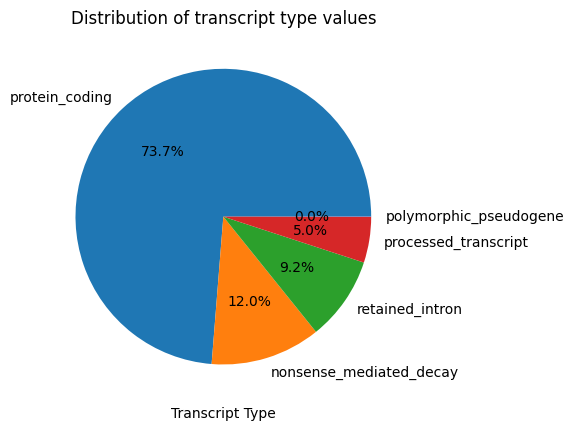

In [142]:
percentage = perc_column('transcript_type')
plt.pie(percentage, labels=percentage.index, autopct='%1.1f%%', startangle=0)
plt.xlabel('Transcript Type')

plt.title('Distribution of transcript type values')
plt.show()

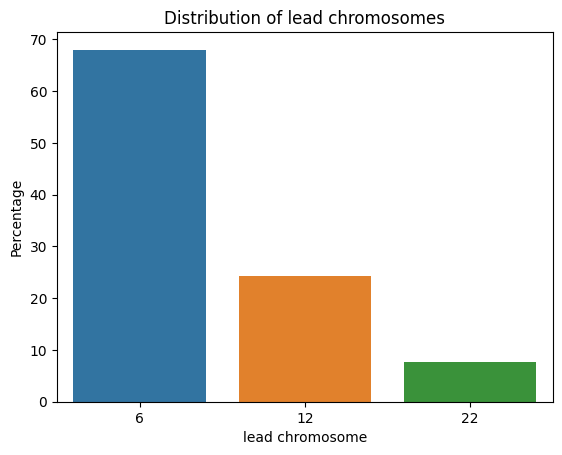

In [143]:
percentage_chr = perc_column('lead_chrom')
# Convert the percentages to a DataFrame for Seaborn plotting
percentage_df = percentage_chr.reset_index()
percentage_df.columns = ['lead chromosome', 'Percentage']

# Plot the percentages as a bar chart with Seaborn
sns.barplot(x='lead chromosome', y='Percentage', data=percentage_df)
plt.title('Distribution of lead chromosomes')
plt.show()

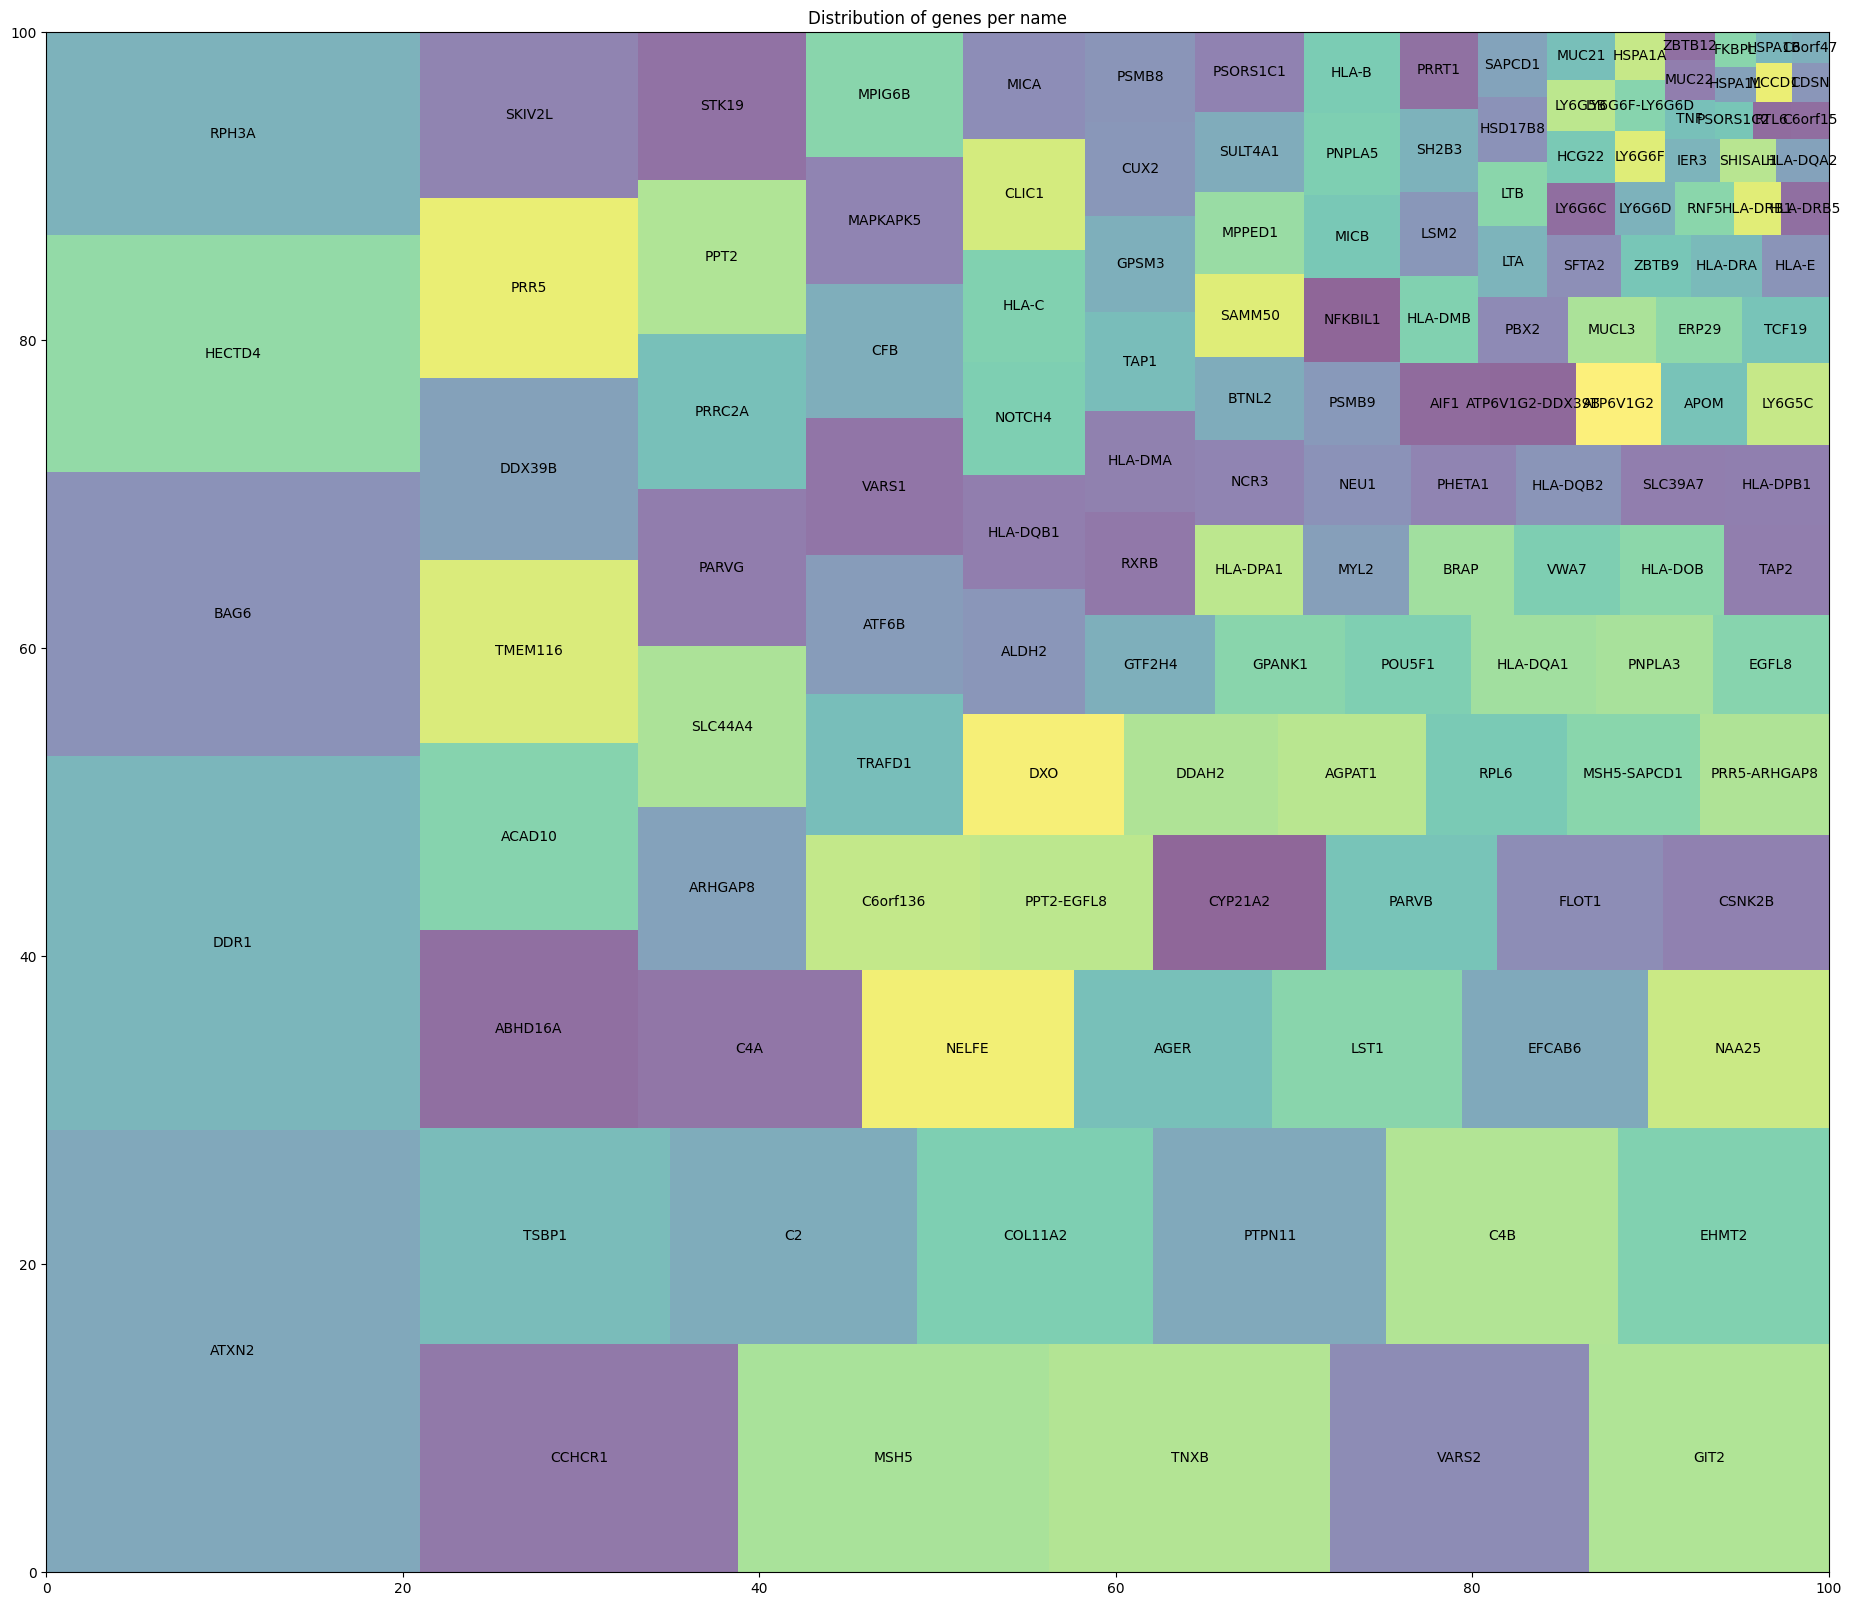

In [146]:
import squarify
perc_gene_name = perc_column('gene_name')
plt.figure(figsize=(23, 20))
squarify.plot(sizes=perc_gene_name, label=perc_gene_name.index, alpha=0.6)

plt.title('Distribution of genes per name')
plt.show()

In [148]:
perc_prot = perc_column('protein_id')
perc_prot = perc_prot.reset_index()
perc_prot.columns = ['protein_id', 'Percentage']
perc_prot = perc_prot.sort_values(by='Percentage', ascending=False)